In [1]:
dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/resized_mfcc_wo_spanish/"
classes = ["mandarin", "india", "english"]



In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display
import os

In [3]:
# mounting the Google Drive 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install python-resize-image

In [8]:
# dataloading utils  

# can load in data from image-conveted dataset 
def generate_data_image(dataset_path):
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(128)])
  train_data = torchvision.datasets.ImageFolder(root=os.path.join(dataset_path,'train'), transform=data_transform)
  test_data = torchvision.datasets.ImageFolder(root=os.path.join(dataset_path,'test'), transform=data_transform)
  val_data = torchvision.datasets.ImageFolder(root=os.path.join(dataset_path,'validation'), transform=data_transform)

  return train_data, val_data, test_data

def visualize_image_data(dataset):
  batch = 27
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data
  classes = ["spanish", "mandarin", "india", "english"]

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  print(images.shape)
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])
  return(images.shape)

# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  data = torchvision.datasets.DatasetFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/resized_mfcc_wo_spanish/', loader=numpy_loader,extensions='.npy',transform=data_transform)
  return data

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['mandarin', 'india', 'english']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0].reshape(128,128))
    plt.colorbar()

In [9]:
# train utils 

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        out = model(imgs) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_confusion_matrix(model, dataset, classes):
    # make a new data loader with batch size 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)

    correct = {} # will be a dictionary where values are also dictionaries. high-level key is actual correct answer, low-level key is predicted answer.
    total = {} # counting totals for every actual correct answer.

    # initialize counters
    for klass in classes:
        correct[klass] = {}
        for klass2 in classes:
            correct[klass][klass2] = 0 
        total[klass] = 0

    # calculate counts for each class
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        out = model(imgs)
        pred = classes[out.max(1, keepdim=True)[1].item()]
        label = classes[labels[0].item()]
        #print(label)
        correct[label][pred] += 1
        total[label] += 1
    
    
    # create final confusion matrix
    for label in correct.keys():
        for pred in correct[label].keys():
            correct[label][pred] = float(correct[label][pred]) / float(total[label])

    return correct

(27, 3, 128, 128)


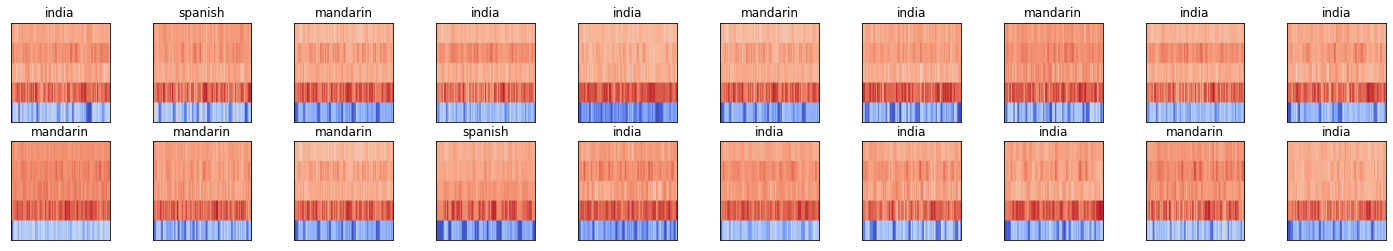

In [10]:
train_data, val_data, test_data= generate_data_image(dataset_path)
dims = visualize_image_data(train_data)

In [12]:
def train_net(net, classes, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    # Train a classifier on sign language images
    # Fixed PyTorch random seed for reproducible result
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    # The loss function will be Cross Entropy and Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            out = net(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        if (epoch>0 and (epoch+1)%10==0):
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
          torch.save(net.state_dict(), model_path)
    
    plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

    print("Confusion Matrix (rows are actual labels, columns are prediction percentages)")
    get_confusion_matrix(net, val_data, classes)

In [53]:
from PIL import Image
import os, sys

path = "/content/drive/My Drive/APS360 Group Project/data_testing/mfcc_wo_spanish/test/english/"
dirs = os.listdir( path )

def resize():
    for item in dirs:
        print("file found")
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((255,255), Image.ANTIALIAS)
            imResize.save('/content/drive/My Drive/APS360 Group Project/data_testing/resized_mfcc_wo_spanish/test/english/' + item + ' resized.jpg', 'JPEG', quality=90)
            print("file saved")

resize()

file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved
file found
file saved


In [14]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [16]:

# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...

import torch
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

trainset = torchvision.datasets.ImageFolder(dataset_path + '/train', transform=transform)
valset = torchvision.datasets.ImageFolder(dataset_path + '/validation', transform=transform)
testset = torchvision.datasets.ImageFolder(dataset_path + '/test', transform=transform)

batch_size = 64
num_workers = 1
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=False)

train_dataiter = iter(train_loader)
train_img, train_label = train_dataiter.next()
train_features = alexnet.features(train_img)

val_dataiter = iter(val_loader)
val_img, val_label = val_dataiter.next()
val_features = alexnet.features(val_img)

test_dataiter = iter(test_loader)
test_img, test_label = test_dataiter.next()
test_features = alexnet.features(test_img)

print(train_features.shape)
print(val_features.shape)
print(test_features.shape)

train_path1 = '/content/drive/My Drive/APS360 Group Project/data_testing/resized_mfcc_wo_spanish/train'
val_path1 = '/content/drive/My Drive/APS360 Group Project/data_testing/resized_mfcc_wo_spanish/validation'
test_path1 = '/content/drive/My Drive/APS360 Group Project/data_testing/resized_mfcc_wo_spanish/test'

torch.Size([64, 256, 6, 6])
torch.Size([64, 256, 6, 6])
torch.Size([64, 256, 6, 6])


In [17]:
test_loader.dataset

Dataset ImageFolder
    Number of datapoints: 200
    Root location: /content/drive/My Drive/APS360 Group Project/data_testing/resized_mfcc_wo_spanish//test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [18]:
import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

batch_size = 1
num_workers = 1
train_loader1 = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader1 = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader1 = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

classes = ["mandarin", "india", "english"]

# save features to folder as tensors
a = 0
for img, label in train_loader1:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  folder_name = train_path1 + '/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(a) + '.tensor')
  a += 1

b = 0
for img, label in val_loader1:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  folder_name = val_path1 + '/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(b) + '.tensor')
  b += 1

c = 0
for img, label in test_loader1:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  folder_name = test_path1 + '/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(c) + '.tensor')
  c += 1

KeyboardInterrupt: ignored

In [19]:
#load features
feature_train_set = torchvision.datasets.DatasetFolder(train_path1, loader=torch.load, extensions=('.tensor'))
feature_val_set = torchvision.datasets.DatasetFolder(val_path1, loader=torch.load, extensions=('.tensor'))
feature_test_set = torchvision.datasets.DatasetFolder(test_path1, loader=torch.load, extensions=('.tensor'))

batch_size = 32
num_workers = 1
feature_train_loader = torch.utils.data.DataLoader(feature_train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
feature_val_loader = torch.utils.data.DataLoader(feature_val_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
feature_test_loader = torch.utils.data.DataLoader(feature_test_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(feature_train_loader)
feature, label = dataiter.next()
print(feature.shape)
print(label.shape)

torch.Size([32, 256, 6, 6])
torch.Size([32])


In [20]:
def train(model, train_loader, val_loader, batch_size=27, num_epochs=1, learn_rate = 0.001):

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    train_acc, val_acc = [], []

    # training
    import time
    start_time = time.time()
    print ("Training Started...")
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1
        
        # track accuracy
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))
        print(epoch, train_acc[-1], val_acc[-1])
    
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
            
    return train_acc, val_acc

In [92]:
# features = ... load precomputed alexnet.features(img) ...
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(256, 160, 5, padding = 2)
        self.fc1 = nn.Linear(160 * 6 * 6, 100)
        self.fc2 = nn.Linear(100, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 160 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
class ANNNet(nn.Module):
    def __init__(self):
        super(ANNNet, self).__init__()
        self.name = "ANNNet 1"
        self.fc1 = nn.Linear(256* 6* 6, 18)
        self.fc2 = nn.Linear(18, 9)

    def forward(self, x):
        x = x.view(-1, 256* 6* 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
class ANNNet2(nn.Module):
    def __init__(self):
        super(ANNNet2, self).__init__()
        self.name = "ANNNet 1.1"
        self.fc1 = nn.Linear(256* 6* 6, 50)
        self.fc2 = nn.Linear(50, 9)

    def forward(self, x):
        x = x.view(-1, 256* 6* 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [40]:
class ANNNet3(nn.Module):
    def __init__(self):
        super(ANNNet3, self).__init__()
        self.name = "ANNNet 1.2"
        self.conv1 = nn.Conv2d(256, 1, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 1 * 5, 32)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 1 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [41]:
nnet7 = ANNNet3()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  nnet7 = nnet7.cuda()
  print('Training on GPU ...')
t_acc, v_acc = train(nnet7, feature_train_loader, feature_val_loader, batch_size=64, num_epochs = 50, learn_rate = 0.001)

plt.plot(range(0,50), t_acc, label='train')
plt.plot(range(0,50), v_acc, label='val')
plt.legend(loc='best')

Training Started...


RuntimeError: ignored

In [35]:
def train_net2(net, train_loader, val_loader, classes, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    # Train a classifier on sign language images
    # Fixed PyTorch random seed for reproducible result
    
    train_loader = train_loader
    val_loader = val_loader
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    # The loss function will be Cross Entropy and Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            out = net(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        if (epoch>0 and (epoch+1)%10==0):
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
          torch.save(net.state_dict(), model_path)
    
    plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

    print("Confusion Matrix (rows are actual labels, columns are prediction percentages)")
    get_confusion_matrix(net, val_data, classes)